In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt
import copy


In [2]:
transform = transforms.ToTensor()

traindataset = datasets.FashionMNIST('.', download=True, train=True, transform=transform)
testdataset = datasets.FashionMNIST('.', download=True, train=False, transform=transform)

In [3]:
batch_size = 16
trainloader = torch.utils.data.DataLoader(traindataset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testdataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [4]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 28*28),
            nn.ReLU()
        )
        self.classifier = nn.Sequential(
            nn.Linear(100, 10),
            nn.LogSoftmax(dim=1)
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        predicted = self.classifier(encoded)
        return decoded, predicted
net = AutoEncoder()
net = net.cuda()
net

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=784, bias=True)
    (3): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=100, out_features=10, bias=True)
    (1): LogSoftmax()
  )
)

In [5]:
criterion1 = nn.MSELoss()
criterion2 = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
classes = ('tshirt','trouser','pullover','dress','coat','sandal','shirt','sneaker','bag','ankle boot')

In [6]:
epochs = 5
for epoch in range(epochs):
    runningloss = 0
  
    for images, labels in trainloader:
        images, labels = images.view(images.size()[0], -1).cuda(), labels.cuda()
        decoded, predicted = net(images)
        optimizer.zero_grad()
        loss1 = criterion1(decoded,images)
        loss2 = criterion2(predicted, labels)
        loss = loss1+loss2
        loss.backward()
        optimizer.step()
        runningloss += loss.item()
  

    net.eval()
    total_correct = 0
    epoch_loss = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.view(images.size()[0], -1).cuda(), labels.cuda()
            decoded, output_acc = net(images)
            test_loss1 = criterion1(decoded,images)
            test_loss2 = criterion2(output_acc, labels)
            test_loss = test_loss1+test_loss2
            _, pred = torch.max(output_acc, 1)
            total_correct += torch.sum(pred==labels).item()
            epoch_loss += test_loss.item()
        accuracy = total_correct / len(testloader.dataset)
    print('Epoch: {}/{} \t Training Loss: {}, Test loss: {}, Test Accuracy: {}'.format(epoch+1, epochs, runningloss/images.shape[0], epoch_loss/images.shape[0], accuracy))

Epoch: 1/5 	 Training Loss: 151.4639257984236, Test loss: 20.032929039094597, Test Accuracy: 0.8421
Epoch: 2/5 	 Training Loss: 108.82493182877079, Test loss: 18.976784917060286, Test Accuracy: 0.8397
Epoch: 3/5 	 Training Loss: 97.85383448004723, Test loss: 18.90054908534512, Test Accuracy: 0.8497
Epoch: 4/5 	 Training Loss: 91.46456070104614, Test loss: 17.85920967068523, Test Accuracy: 0.8577
Epoch: 5/5 	 Training Loss: 86.62855336489156, Test loss: 15.729627611581236, Test Accuracy: 0.8726


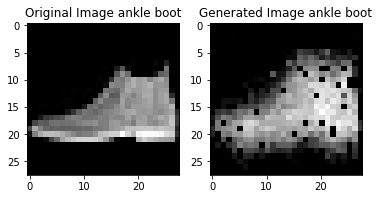

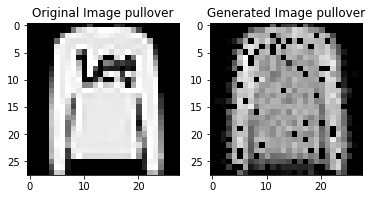

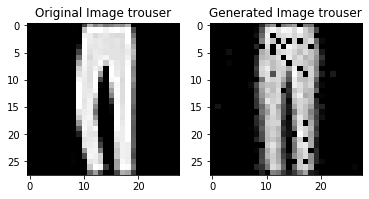

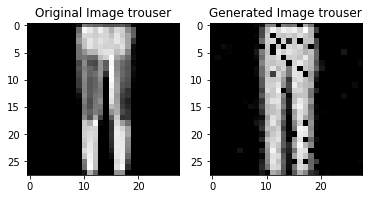

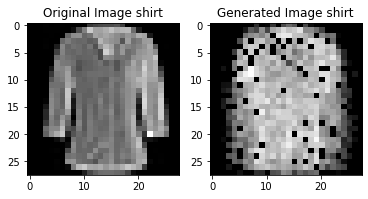

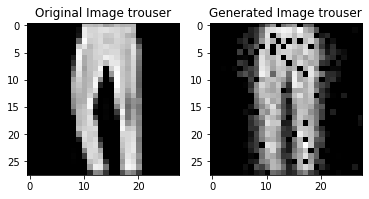

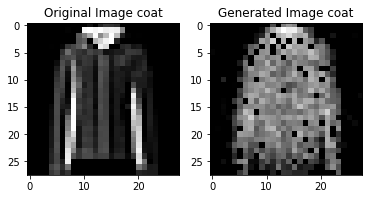

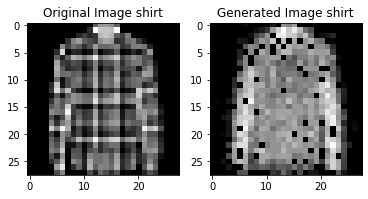

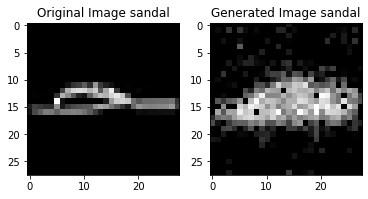

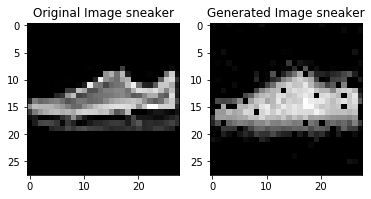

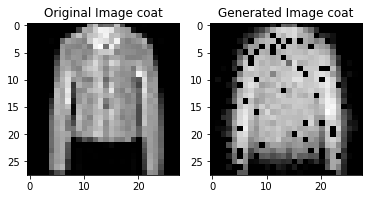

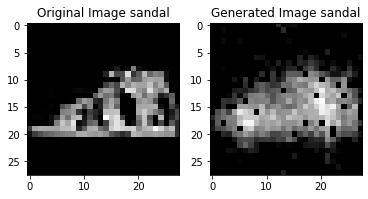

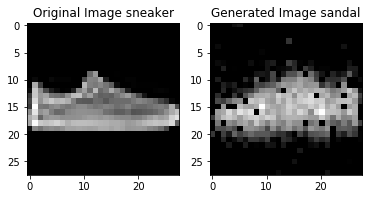

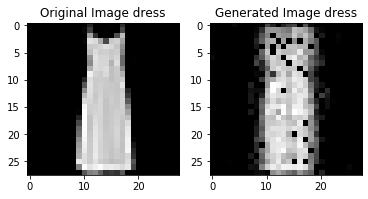

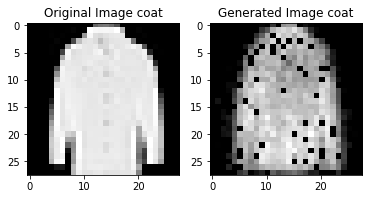

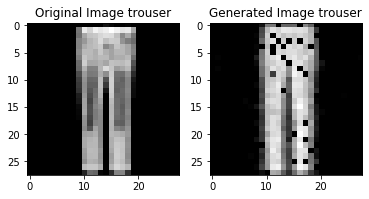

In [18]:
test_images, labels = next(iter(testloader))

test_images = test_images.view(test_images.size()[0], -1).cuda()
test_output, predicted = net(test_images)
_, predicted_label = torch.max(predicted, 1)
  
inp = test_images.view(-1, 28, 28)
out = test_output.view(-1, 28, 28)

for i in range(len(inp)):
    fig = plt.figure()
    plot = fig.add_subplot(1, 2, 1)
    plot.set_title('Original Image ' + str(classes[labels[i]]))
    imgplot = plt.imshow(inp[i].cpu(), cmap='gray')
    #print("Ground truth", classes[labels[i]])
    plot = fig.add_subplot(1, 2, 2)
    plot.set_title('Generated Image ' + str(classes[predicted_label[i]]))
    imgplot = plt.imshow(out[i].cpu().detach(), cmap='gray')
    #print("Predicted", classes[predicted_label[i]])
    plt.show()

In [19]:

class_correct = np.array([0.] * 10)
class_total = np.array([0.] * 10)
for data in testloader:
    images, labels = data
    decoded, outputs = net(Variable(images.view(-1, 28*28).cuda()))
    _, predicted = torch.max(outputs.cpu(), 1)
    c = (predicted == labels)
    for i in range(batch_size):
        label = labels[i].item()
        class_correct[label] += c[i].item()
        class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %f %%' % (classes[i], 100 * class_correct[i] / float(class_total[i])))

Accuracy of tshirt : 77.400000 %
Accuracy of trouser : 96.100000 %
Accuracy of pullover : 82.800000 %
Accuracy of dress : 92.500000 %
Accuracy of  coat : 75.800000 %
Accuracy of sandal : 96.200000 %
Accuracy of shirt : 65.500000 %
Accuracy of sneaker : 94.700000 %
Accuracy of   bag : 97.200000 %
Accuracy of ankle boot : 94.100000 %


In [21]:
#NOT IN USE
correct = 0
total = 0
with torch.no_grad():
    for images,labels in testloader:
        images, labels = images.view(images.size()[0], -1).cuda(), labels.cuda()
        decoded, output_acc = net(images)
        _, predicted = torch.max(output_acc, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy of the network: %.3f %%' % (
    100 * correct / total))

Accuracy of the network: 84.780 %


In [19]:
#NOT CURRENTLY IN USE - JUST THE AUTOENCODER ITSELF
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 28*28),
            nn.ReLU()
        )
  
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
net = AutoEncoder()
net = net.cuda()
net

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=784, bias=True)
    (3): ReLU()
  )
)

In [4]:
optimizer = optim.SGD(net.parameters(), lr=0.5, momentum=0.9)
criterion = nn.MSELoss()

NameError: name 'net' is not defined

In [21]:
#NOT CURRENTLY IN USE - TRAINING THE AUTOENCODER BY ITSELF
epochs = 5
for epoch in range(epochs):
    runningloss = 0
  
    for images, labels in trainloader:
        images, labels = images.view(images.size()[0], -1).cuda(), labels.cuda()
        optimizer.zero_grad()
        output = net(images)
        loss = criterion(output, images.view(images.size()[0], -1))
        loss.backward()
        optimizer.step()
        runningloss += loss.item()/images.shape[0]
    print('Epoch: {}/{} \t Mean Square Error Loss: {}'.format(epoch+1, epochs, runningloss))

Epoch: 1/5 	 Mean Square Error Loss: 8.741306127049029
Epoch: 2/5 	 Mean Square Error Loss: 5.420741587877274
Epoch: 3/5 	 Mean Square Error Loss: 4.877352174546104
Epoch: 4/5 	 Mean Square Error Loss: 4.546721620950848
Epoch: 5/5 	 Mean Square Error Loss: 4.35326160461409


In [26]:
epochs = 5
for epoch in range(epochs):
    runningloss = 0
  
    for images, labels in testloader:
        images, labels = images.view(images.size()[0], -1).cuda(), labels.cuda()
        output = net(images)
        #print(images.shape) #16x784
        #print(labels.shape) #16
        #print(output.shape) #16x10
        optimizer.zero_grad()
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        runningloss += loss.item()/images.shape[0]
  

    net.eval()
    total_correct = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.view(images.size()[0], -1).cuda(), labels.cuda()
            output_acc = net(images)
            _, pred = torch.max(output_acc, 1)
            total_correct += torch.sum(pred==labels).item()
        accuracy = total_correct / len(testloader.dataset)
    print('Epoch: {}/{} \t Training Loss: {}, Test Accuracy: {}'.format(epoch, epochs, runningloss, accuracy))



Epoch: 0/5 	 Training Loss: 35.89347675256431, Test Accuracy: 0.776
Epoch: 1/5 	 Training Loss: 22.122648192569613, Test Accuracy: 0.7911
Epoch: 2/5 	 Training Loss: 19.59754120418802, Test Accuracy: 0.8147
Epoch: 3/5 	 Training Loss: 18.04532377142459, Test Accuracy: 0.8317
Epoch: 4/5 	 Training Loss: 16.867803036700934, Test Accuracy: 0.8366


In [11]:
#NOT CURRENTLY IN USE - REPLACE THE DECODER WITH A CLASSIFIER
new_classifier = nn.Sequential(*list(net.children())[:-1])
net = new_classifier
net.add_module('classifier', nn.Sequential(nn.Linear(100, 10),nn.LogSoftmax(dim=1)))
net.cuda()
net

Sequential(
  (0): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=100, out_features=10, bias=True)
    (1): LogSoftmax()
  )
)